In [1]:
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('test_basic.csv')

In [4]:
df.head()

,user_id,conversion,test
0,860955,0,0
1,911569,0,1
2,673989,0,0
3,562761,0,0
4,64288,0,0


In [7]:
df['test'].value_counts()

1    41512
0    37431
Name: test, dtype: int64

## T-test

In [8]:
df.groupby('test')['conversion'].mean()

test
0    0.043707
1    0.055598
Name: conversion, dtype: float64

In [18]:
g0 = df[df['test']==0]['conversion']
g1 = df[df['test']==1]['conversion']

ttest = stats.ttest_ind(g1, g0, equal_var=False)

In [19]:
print(ttest)

Ttest_indResult(statistic=7.705449851546837, pvalue=1.3189559402908635e-14)


In [22]:
if ttest.pvalue <= 0.05:
    if ttest.statistic > 0:
        print("Experimental group is better than control group")
    else:
        print("Experimental group is worse than control group")
else:
    print("The difference is not significant")

Experimental group is better than control group


## Sample size calcultaion

In [27]:
p1_p2 = sms.proportion_effectsize(0.1, 0.11)
sample_size = sms.NormalIndPower().solve_power(p1_p2, power=0.8, alpha=0.05)  # power and significant level are usually the same

print(round(sample_size))

14744


### Sample size vs. minimum effect

In [31]:
possible_p2 = np.arange(.105, .155, .005)
print(possible_p2)

[0.105 0.11  0.115 0.12  0.125 0.13  0.135 0.14  0.145 0.15 ]


In [33]:
size = []

for p in possible_p2:
    p1_p2 = sms.proportion_effectsize(0.1, p)
    s = sms.NormalIndPower().solve_power(p1_p2, power=0.8, alpha=0.05)
    size.append(s)

In [37]:
sns.set_theme()

If we are looking for a very small gain, we need a lot of data to find it. But if we are looking for a huge gain like from 10% to 15% conversion rate, few data will be enough to check if that’s happening or not.

Text(0, 0.5, 'Minimum effect')

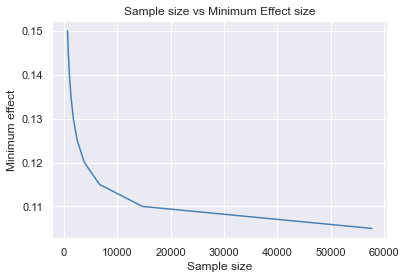

In [38]:
sns.lineplot(x=size, y=possible_p2, color='steelblue')

plt.title('Sample size vs Minimum Effect size')
plt.xlabel('Sample size')
plt.ylabel('Minimum effect')

## Randomisation

In [2]:
df = pd.read_csv('randomization.csv')

In [40]:
df.head()

,user_id,source,device,browser_language,browser,sex,age,country,test,conversion
0,1,SEO,Web,EN,Chrome,M,38,Chile,0,0
1,2,SEO,Mobile,ES,Android_App,M,27,Colombia,0,0
2,3,SEO,Mobile,ES,Iphone_App,M,18,Guatemala,1,0
3,5,Ads,Web,ES,Chrome,M,22,Argentina,1,0
4,8,Ads,Mobile,ES,Android_App,M,19,Venezuela,1,0


In [59]:
source = df.groupby(['source', 'test']).size().unstack()
source_pct = source.div(source.sum())

The percentages of source between experimental group and control group are similar.

In [60]:
source_pct

test,0,1
source,,
Ads,0.401228,0.400641
Direct,0.200949,0.199500
SEO,0.397823,0.399858


### Modelling check

In [3]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source

In [4]:
df.drop('user_id', axis=1, inplace=True)

df_dummy = pd.get_dummies(df)

# test is the model target and conversion is no need to check
features = df_dummy.drop(['test', 'conversion'], axis=1)

tree = DecisionTreeClassifier(
    class_weight='balanced',
    min_impurity_decrease = 0.001
)

tree.fit(features, df_dummy['test'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [5]:
export_graphviz(tree, out_file="tree_test.dot", feature_names=features.columns, proportion=True, rotate=True)

In [7]:
s = Source.from_file("tree_test.dot")
s.view()


# we can see that test and control are not the same! Users from Argentina and Uruguay are way more likely to be in test 
# than control. When country_Argentina is 1, the tree shows that users in control are ~23% and in test 73% instead of 50/50. 
# For Uruguay, the proportions are even more extreme: 11% in control and 89% in test


'tree_test.dot.pdf'

### Manual check

In [10]:
df_dummy.groupby('test')['country_Argentina', 'country_Uruguay'].mean()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,country_Argentina,country_Uruguay
test,,
0,0.050488,0.002239
1,0.173223,0.017236


### T-test

In [13]:
g0 = df_dummy[df_dummy['test']==0]['conversion']
g1 = df_dummy[df_dummy['test']==1]['conversion']

ttest_all = stats.ttest_ind(g0, g1, equal_var=False)

In [15]:
# remove the two siginificantly different countries

df_remove = df_dummy[(df_dummy['country_Argentina']==0) & (df_dummy['country_Uruguay']==0)]

g0 = df_remove[df_remove['test']==0]['conversion']
g1 = df_remove[df_remove['test']==1]['conversion']

ttest_remove = stats.ttest_ind(g0, g1, equal_var=False)

In [16]:
# after removing the twocountries, the distribution of the data is balanced

print(ttest_all)
print(ttest_remove)

Ttest_indResult(statistic=7.353895203080277, pvalue=1.9289178577799033e-13)
Ttest_indResult(statistic=-0.3583455794481447, pvalue=0.7200849282884503)
